Import

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

Ouverture du fichier csv de data 

In [118]:

df = pd.read_csv("../data/marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Je vois qu'on a des colonnes qu'on pourra encoder

In [119]:

print("Nombre de doublons :", df.duplicated().sum())

print("Valeurs nulles par colonne :\n", df.isnull().sum())

Nombre de doublons : 0
Valeurs nulles par colonne :
 ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


Aucune valeur null ni doublon

Suppressions des colonnes comportant une seule valeur, ou inutile

In [120]:
# Identifier et supprimer les colonnes avec une seule valeur unique
delete_columns = []
for col in df.columns:
    if df[col].nunique() == 1:
        delete_columns.append(col)
        print(f"Colonne {col}")

df = df.drop(columns=delete_columns)
print(f"{len(delete_columns)} colonne(s) supprimée(s)")
print(f"Forme du dataframe: {df.shape}")

Colonne Z_CostContact
Colonne Z_Revenue
2 colonne(s) supprimée(s)
Forme du dataframe: (2240, 27)


In [121]:
useless_columns = ["ID"]
df = df.drop(columns=useless_columns)

Matrice de corrélation

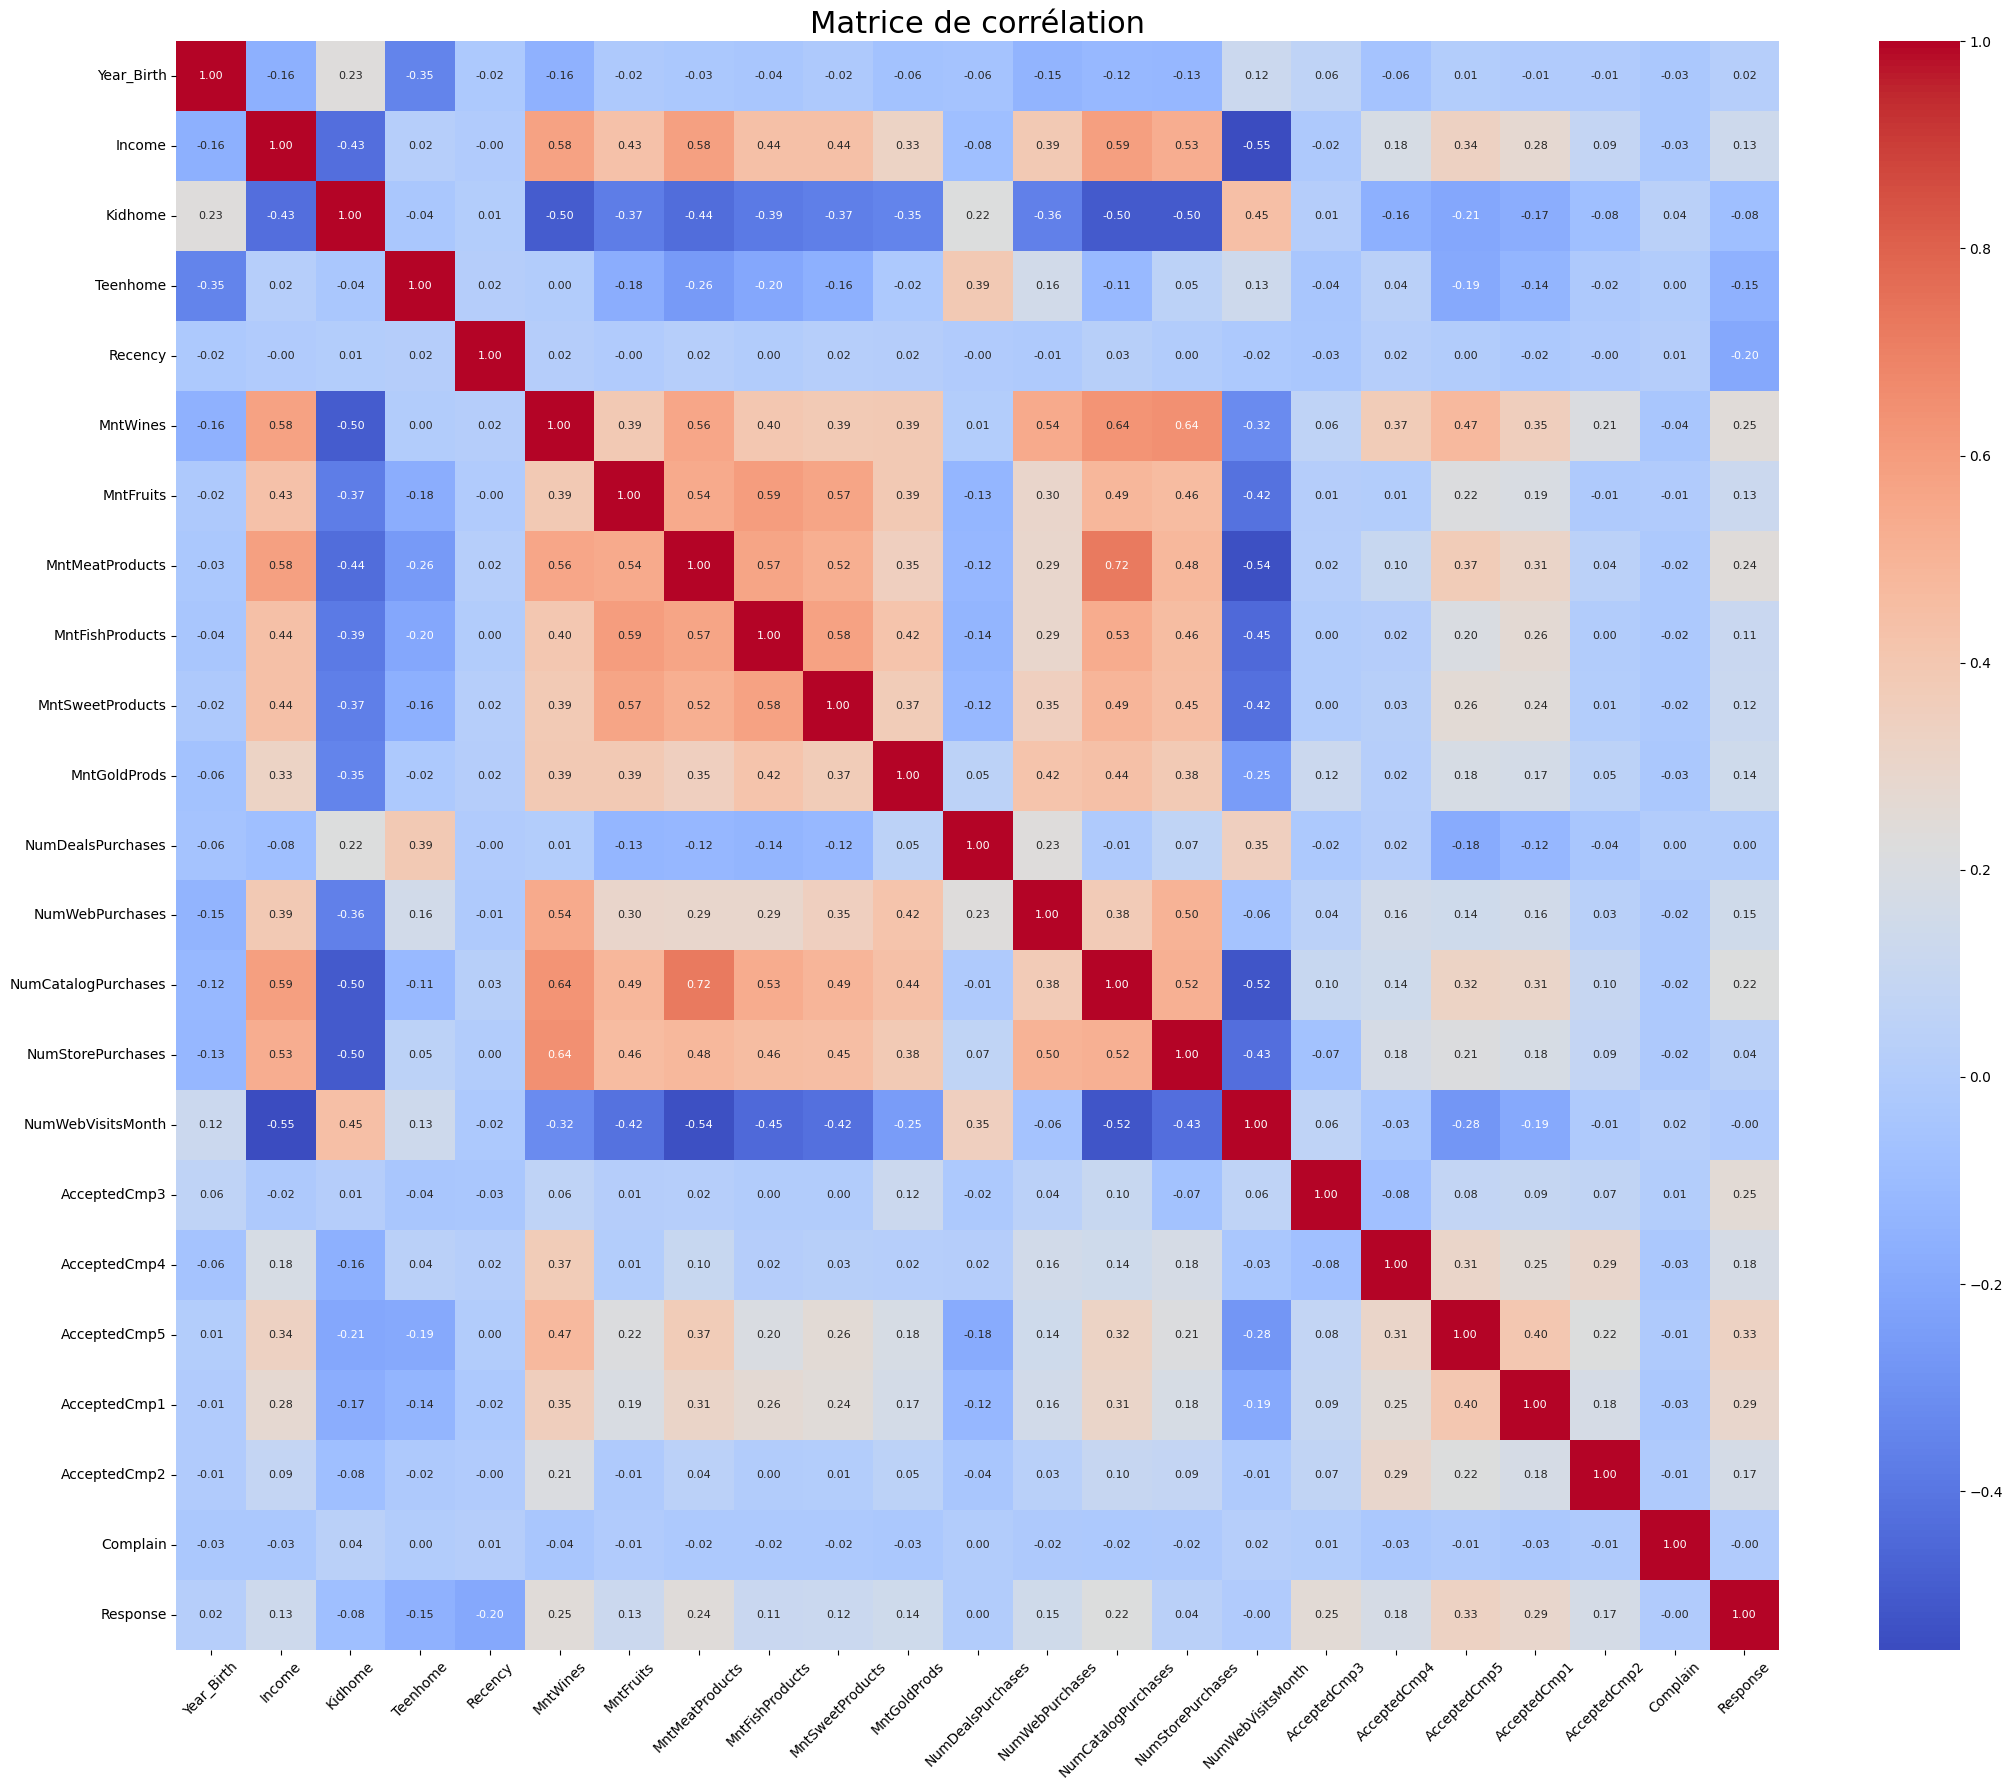

In [122]:
plt.figure(figsize=(22, 18))  
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8}  
)
plt.title("Matrice de corrélation", fontsize=22)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()  
plt.show()

On voie des colonne qui on de forte corrélation entre elle 

Verification outliers

Outliers les plus important à normaliser sont les accepted campaigns car naturellement elles sont corrlé avec la response

In [123]:
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

for col in colonnes_numeriques:
    moyenne = df[col].mean()
    ecart_type = df[col].std()
    outliers = df[(df[col] < moyenne - 3 * ecart_type) | (df[col] > moyenne + 3 * ecart_type)]
    print(f"{col}: {len(outliers)} outliers")

Year_Birth: 3 outliers
Income: 8 outliers
Kidhome: 0 outliers
Teenhome: 0 outliers
Recency: 0 outliers
MntWines: 16 outliers
MntFruits: 64 outliers
MntMeatProducts: 37 outliers
MntFishProducts: 58 outliers
MntSweetProducts: 62 outliers
MntGoldProds: 44 outliers
NumDealsPurchases: 32 outliers
NumWebPurchases: 4 outliers
NumCatalogPurchases: 4 outliers
NumStorePurchases: 0 outliers
NumWebVisitsMonth: 9 outliers
AcceptedCmp3: 163 outliers
AcceptedCmp4: 167 outliers
AcceptedCmp5: 163 outliers
AcceptedCmp1: 144 outliers
AcceptedCmp2: 30 outliers
Complain: 21 outliers
Response: 0 outliers


On va voir la répartition des données 

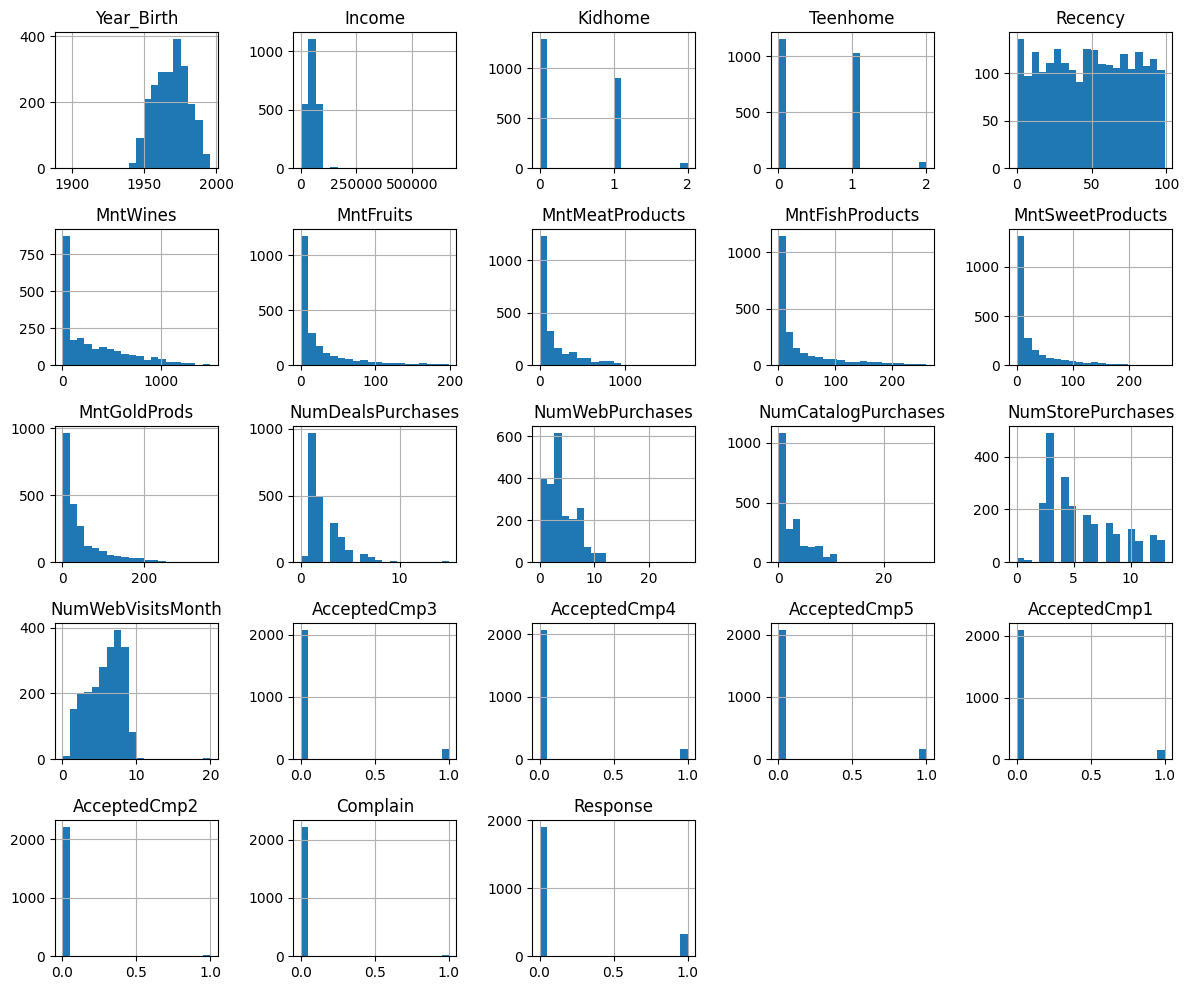

In [124]:
colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

Pour normaliser les donénes, il est préférable d'utiliser la médiane, car on remarque qui y a un ecart énorme entre la valeurs 0 que 1

### Pipeline

In [125]:
accepted_columns = [x for x in df.columns if "AcceptedCmp" in x]
accepted_columns


['AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2']

In [126]:
target = "Response"

y = df[target].astype(int)
X = df.drop(columns=[target])

In [127]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # ✅ stratification sur la cible
)

print("Train y distribution:\n", y_train.value_counts(normalize=True))
print("Valid y distribution:\n", y_test.value_counts(normalize=True))

Train y distribution:
 Response
0    0.851004
1    0.148996
Name: proportion, dtype: float64
Valid y distribution:
 Response
0    0.850446
1    0.149554
Name: proportion, dtype: float64


In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = accepted_columns
cat_features = ["Education", "Marital_Status"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [129]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat_non_ord", categorical_pipeline, cat_features),
    ],
    remainder="drop"
)

In [130]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, random_state=42)


pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

In [131]:
pipe.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_non_ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [132]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [133]:
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8594
F1-score:  0.3762

Confusion matrix:
 [[366  15]
 [ 48  19]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       381
           1       0.56      0.28      0.38        67

    accuracy                           0.86       448
   macro avg       0.72      0.62      0.65       448
weighted avg       0.84      0.86      0.84       448



In [134]:
import pickle

# Sauvegarde du pipeline complet (prétraitement + modèle)
with open("ecommerce_model.pkl", "wb") as f:
    pickle.dump(pipe, f)

print("Modèle sauvegardé dans ecommerce_model.pkl")

Modèle sauvegardé dans ecommerce_model.pkl


In [136]:
with open("ecommerce_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [137]:
df

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,...,3,6,5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,...,3,4,5,0,0,0,0,0,0,0
2236,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,...,2,5,7,0,0,0,1,0,0,0
2237,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,...,3,13,6,0,1,0,0,0,0,0
2238,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,...,5,10,3,0,0,0,0,0,0,0


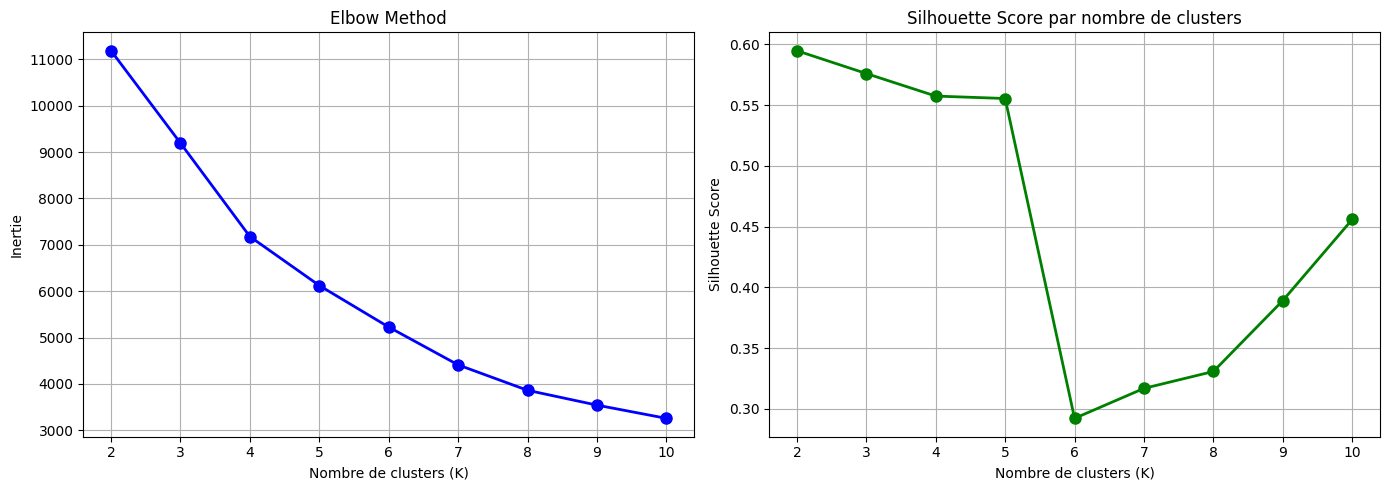


✅ Clustering avec K=3
Distribution des clusters :
0     161
1    2049
2      30
Name: count, dtype: int64

Silhouette Score: 0.5760
Davies-Bouldin Score: 1.1002


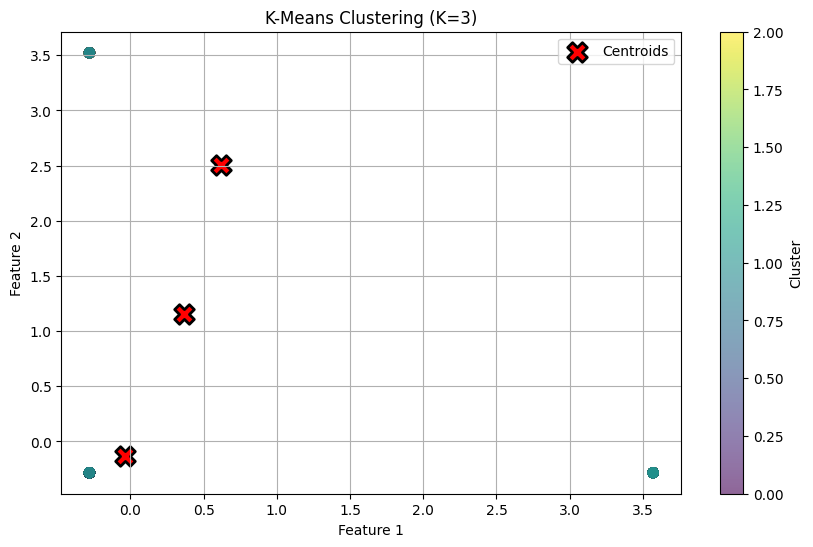

In [147]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Utiliser les données transformées par le preprocessor
X_transformed = preprocessor.fit_transform(X)

# Déterminer le nombre optimal de clusters (Elbow Method)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_transformed)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_transformed, kmeans.labels_))

# Afficher les courbes
plt.figure(figsize=(14, 5))

# Graphique 1 : Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie")
plt.title("Elbow Method")
plt.grid()

# Graphique 2 : Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score par nombre de clusters")
plt.grid()

plt.tight_layout()
plt.show()

# Utiliser le meilleur K (par exemple K=3)
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_transformed)

# Ajouter les clusters au dataframe original
df['Cluster'] = clusters

print(f"\n✅ Clustering avec K={best_k}")
print(f"Distribution des clusters :\n{pd.Series(clusters).value_counts().sort_index()}")
print(f"\nSilhouette Score: {silhouette_score(X_transformed, clusters):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_transformed, clusters):.4f}")

# Visualiser les clusters (sur les 2 premières composantes)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, edgecolors='black', linewidth=2, label='Centroids')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"K-Means Clustering (K={best_k})")
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid()
plt.show()

In [146]:
import pandas as pd

# Supposons que ton DataFrame s'appelle df
# Créer le dictionnaire du nouveau client
new_client = {
    "Year_Birth": 2026,
    "Education": "Master",
    "Marital_Status": "Single",
    "Income": 900.0,
    "Kidhome": 0,
    "Teenhome": 1,
    "Dt_Customer": "15-01-2026",
    "Recency": 10,
    "MntWines": 100,
    "MntFruits": 20,
    "MntMeatProducts": 1,
    "MntFishProducts": 10,
    "MntSweetProducts": 1,
    "MntGoldProds": 0,
    "NumDealsPurchases": 0,
    "NumWebPurchases": 0,
    "NumCatalogPurchases": 0,
    "NumStorePurchases": 1,
    "NumWebVisitsMonth": 0,
    "AcceptedCmp3": 0,
    "AcceptedCmp4": 0,
    "AcceptedCmp5": 1,
    "AcceptedCmp1": 0,
    "AcceptedCmp2": 0,
    "Complain": 0,
    "Response": 0
}

# Ajouter le nouveau client
prediction = loaded_model.predict(pd.DataFrame([new_client]))[0]
proba = loaded_model.predict_proba(pd.DataFrame([new_client]))[0][1]

print(prediction, "Réponse prédite")
print(proba, "Probabilité associée")

0 Réponse prédite
0.47406579858607867 Probabilité associée
